In [3]:
%pip install pandas matplotlib requests tqdm openpyxl



Note: you may need to restart the kernel to use updated packages.


c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openai.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-05-06 09:38:42,613 - INFO - API key is valid.
Processing users: 0it [00:00, ?it/s]c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openai.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-05-06 09:38:44,719 - INFO - User John Doe asked: 'What is the weather like today?', received: I'm sorry, but I don't have real-time information on the weather. You can check the weather for your location by using a weather website

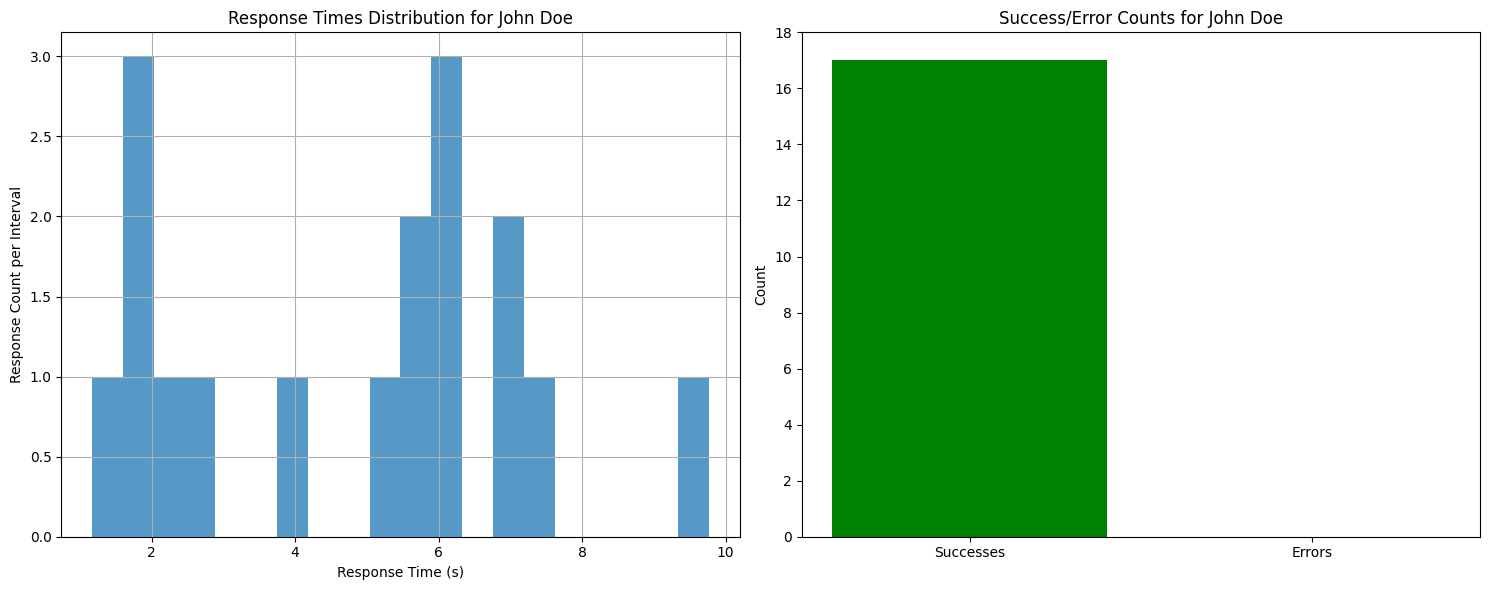

Processing users: 1it [01:21, 81.82s/it]c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openai.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-05-06 09:40:06,587 - INFO - User Jane Smith asked: 'What is the weather like today?', received: I'm sorry, but I don't have access to real-time information such as weather updates. You can check the weather for your location by using a weather app on your phone or by visiting a weather website.
c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openai.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warning

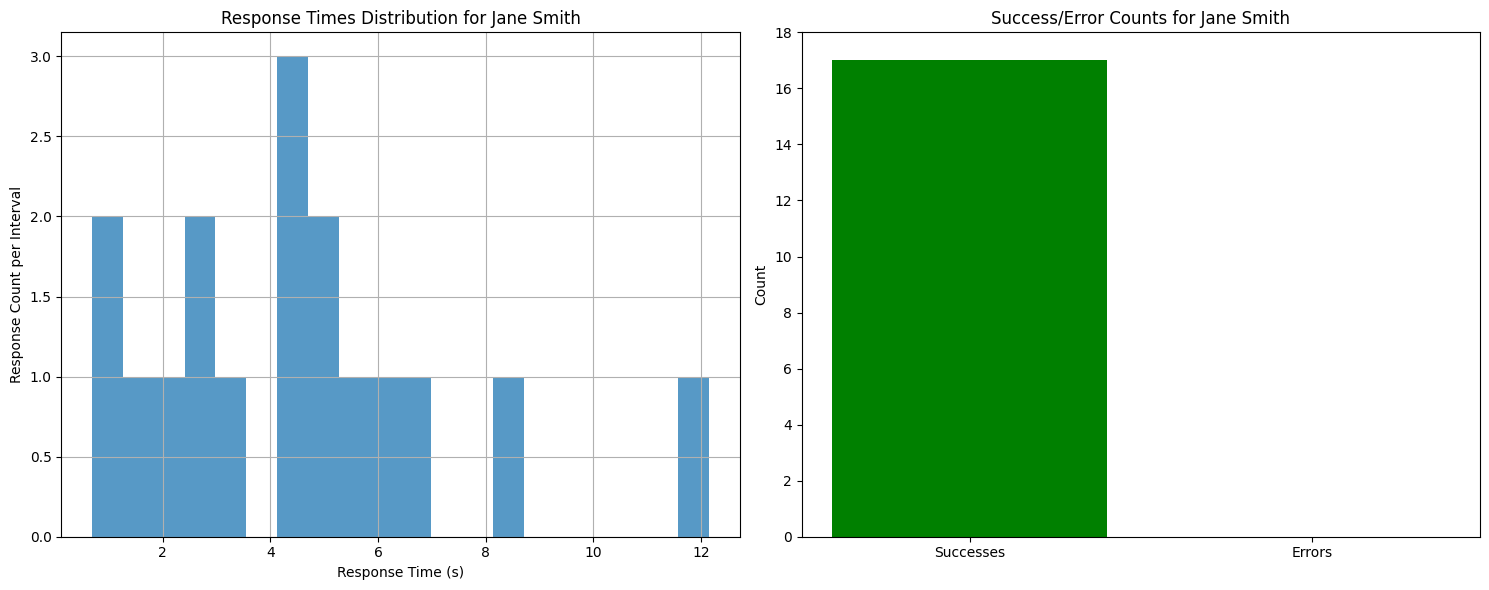

Processing users: 2it [02:38, 78.92s/it]c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openai.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-05-06 09:41:23,279 - INFO - User Michael Jones asked: 'What is the weather like today?', received: I'm sorry, I cannot provide real-time weather updates as I don't have access to the internet to check for the current weather conditions. You can check the weather in your location by using a weather website or app on your device.
c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openai.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/late

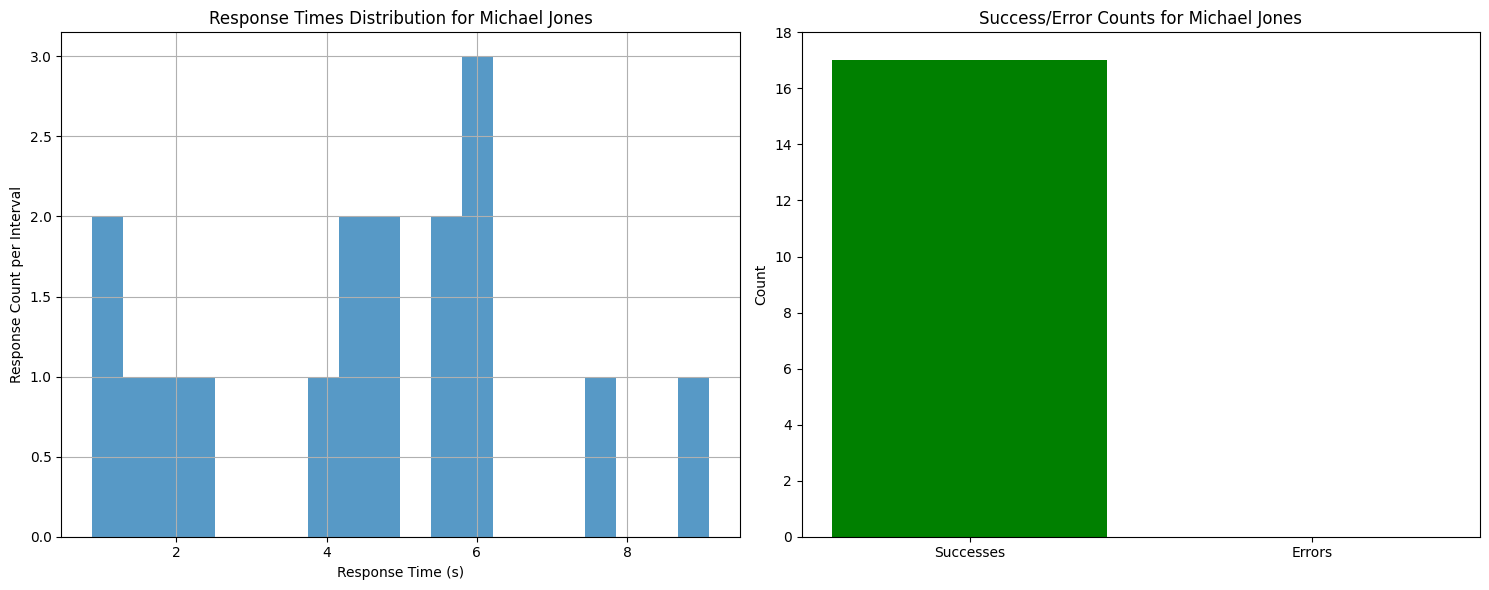

Processing users: 3it [03:54, 78.13s/it]


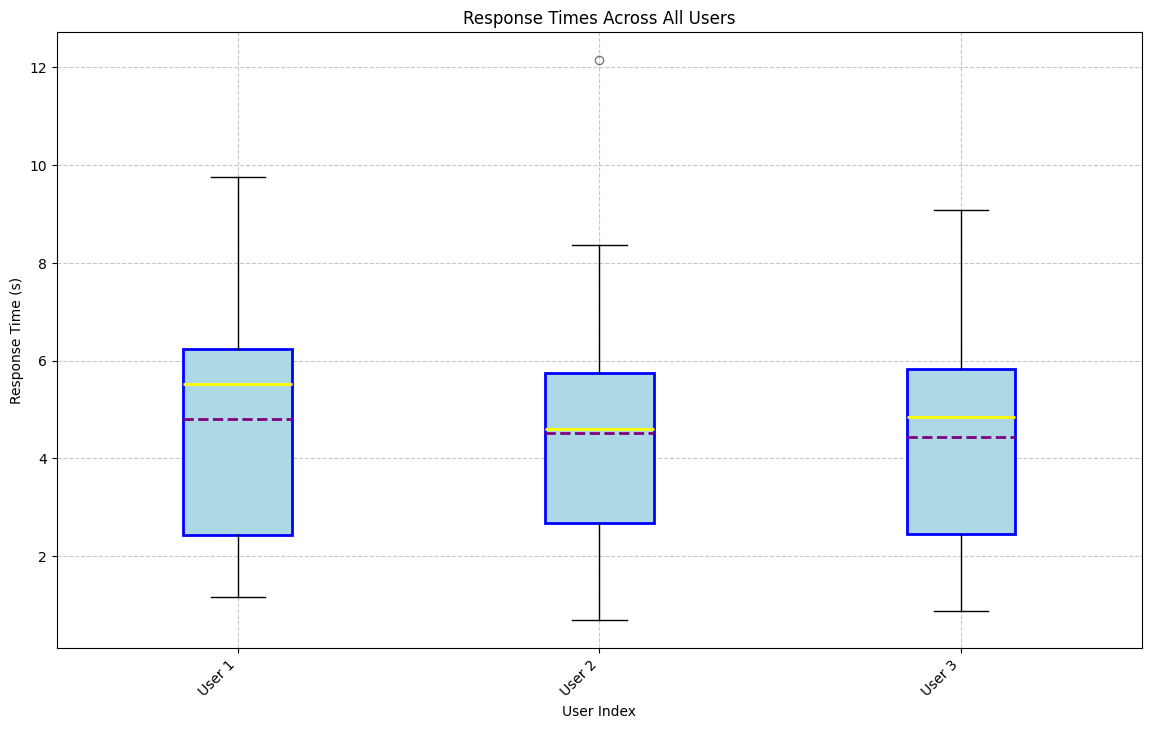

In [1]:
import requests
import pandas as pd
import time
import logging
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt

# Basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_config():
    try:
        with open('config-chatgpt.json', 'r') as config_file:
            config = json.load(config_file)
        check_api_key(config['openai_api_key'])  # Call to validate API key
        return config
    except FileNotFoundError:
        logging.error("Configuration file 'config-chatgpt.json' not found.")
        raise FileNotFoundError("Configuration file 'config-chatgpt.json' not found.")
    except KeyError:
        logging.error("API key not found in configuration.")
        raise KeyError("API key not found in configuration file.")
    
def check_api_key(api_key):
    """ Check if the OpenAI API key is valid """
    url = "https://api.openai.com/v1/engines"
    headers = {"Authorization": f"Bearer {api_key}"}
    response = requests.get(url, headers=headers, verify=False)
    if response.status_code == 200:
        logging.info("API key is valid.")
    else:
        logging.error(f"API key is not valid. Status code: {response.status_code}")
        raise ValueError(f"API key is not valid. Status code: {response.status_code}")


config = load_config()

def load_users(filename):
    return pd.read_excel(filename)

def load_questions(filename):
    with open(filename, "r") as f:
        return [line.strip() for line in f if line.strip()]

def send_question(user, question):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {config['openai_api_key']}",
        "Content-Type": "application/json",
    }
    payload = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": question}
        ]
    }
    start = time.time()
    try:
        response = requests.post(url, json=payload, headers=headers, verify=False)
        response.raise_for_status() # This will raise an HTTPError for HTTP error responses
        return {"time": time.time() - start, "data": response.json(), "error": None}
    except requests.exceptions.RequestException as e:
        logging.error(f"Error sending question for user {user['name']}: {e}")
        return {"time": time.time() - start, "data": None, "error": str(e)}

def run_test():
    users = load_users(config["user_file"])
    questions = load_questions(config["question_file"])
    total_response_times = []
    total_errors = []

    for index, user in enumerate(tqdm(users.iterrows(), desc="Processing users"), start=1):
        user_data = user[1]
        user_response_times = []
        success_count = 0
        error_count = 0

        for question in questions:
            result = send_question(user_data, question)
            user_response_times.append(result["time"])
            if result["error"]:
                error_count += 1
                logging.info(f"User {user_data['name']} asked: '{question}', error: {result['error']}")
            else:
                success_count += 1
                logging.info(f"User {user_data['name']} asked: '{question}', received: {result['data'].get('choices', [{}])[0].get('message', {}).get('content')}")

        total_response_times.append(user_response_times)
        total_errors.append((success_count, error_count))
        plot_user_response_times(user_data, user_response_times, success_count, error_count)

    plot_response_times_across_users(total_response_times)

'''
The first plot is a histogram of response times for a specific user. 
The y-axis label 'Frequency' makes sense here as histograms typically display frequency distributions.

The second plot is a bar chart showing the number of successes and errors for the same user. 
The y-axis label 'Count' is appropriate here as we're counting the number of successes and errors.
'''

def plot_user_response_times(user_data, response_times, success_count, error_count):
    # Create a figure and two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

    # First plot: Response Times Distribution
    ax1.hist(response_times, bins=20, alpha=0.75, color='tab:blue')
    ax1.set_title(f"Response Times Distribution for {user_data['name']}")
    ax1.set_xlabel('Response Time (s)')
    ax1.set_ylabel('Response Count per Interval')  # Updated label for clarity
    ax1.grid(True)

    # Second plot: Success/Error Counts
    ax2.bar(['Successes', 'Errors'], [success_count, error_count], color=['green', 'red'])
    ax2.set_title(f'Success/Error Counts for {user_data["name"]}')
    ax2.set_ylabel('Count')
    ax2.set_ylim(0, max(success_count, error_count) + 1)  # Adjust y limit to ensure bars are fully visible

    plt.tight_layout()  # Adjust the layout so that both plots are neatly arranged
    plt.show()


''' 
Yellow Line: This represents the median of the response times. 
The median is the middle value when the data are arranged in order, 
providing a good indicator of the typical response time by cutting the data set in half.

Purple Dashed Line: This represents the mean (average) of the response times. 
The mean is calculated by adding all response times and dividing by the number of response times. 
This gives a sense of the central tendency of the data but can be influenced by outliers.

Using both in the plot allows users to quickly assess the skewness of the data:

If the mean and median are close together, the data are more symmetrically distributed.
If the mean is higher than the median, the data might be right-skewed, 
indicating that there are some unusually high response times pulling the average up.
These visual indicators are crucial for understanding the overall performance characteristics of the API under test, 
especially in the context of volume testing where response consistency is key.
'''
def plot_response_times_across_users(total_response_times):
    num_users = len(total_response_times)
    fig, ax = plt.subplots(figsize=(14, 8))

    boxprops = dict(linestyle='-', linewidth=2, color='blue')
    flierprops = dict(marker='o', color='red', alpha=0.5)
    medianprops = dict(linestyle='-', linewidth=2, color='yellow')

    bp = ax.boxplot(total_response_times, patch_artist=True, labels=[f"User {i}" for i in range(1, num_users + 1)],
                    boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                    showmeans=True, meanline=True, meanprops=dict(linestyle='--', linewidth=2, color='purple'))

    for box in bp['boxes']:
        box.set(facecolor = 'lightblue')

    ax.set_title('Response Times Across All Users')
    ax.set_xlabel('User Index')
    ax.set_ylabel('Response Time (s)')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.show()

if __name__ == "__main__":
   run_test()


